In [1]:
import os, sys
import cv2
import numpy as np
import json
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm, trange
import copy
import scipy
from scipy import optimize


import matplotlib.pyplot as plt
import pdb
from progressbar import ProgressBar

from config import gen_args
from data_utils import load_data, get_scene_info
from models import Model
from utils import create_instance_colors, set_seed,  Tee, count_parameters
from data_utils import get_env_group, prepare_input

In [2]:
class Planner(object):

    def __init__(self, args, n_his, n_particle, n_shape, scene_params, model, dist_func, use_gpu, beta_filter=1, env="gripper"):
        self.args = args
        self.n_his = n_his
        self.n_particle = n_particle
        self.n_shape = n_shape
        self.scene_params = scene_params
        self.beta_filter = beta_filter
        self.env = env
        self.model = model
        self.dist_func = dist_func
        self.use_gpu = use_gpu
        self.n_sample = 100
        self.reward_weight = 1
    
    def trajectory_optimization(
        self,
        state_cur,      # [n_his, state_dim]
        state_goal,     # [state_dim]
        act_seq,        # [n_his + n_look_ahead - 1, action_dim]
        n_sample,
        n_look_ahead,
        n_update_iter,
        action_lower_lim,
        action_upper_lim,
        action_lower_delta_lim,
        action_upper_delta_lim,
        use_gpu,
        reward_scale_factor=1.):

        for i in range(n_update_iter):
            act_seqs = self.sample_action_sequences(
                act_seq, n_sample,
                action_lower_lim, action_upper_lim,
                action_lower_delta_lim, action_upper_delta_lim)
            state_seqs = self.model_rollout(
                state_cur, act_seqs, n_look_ahead, use_gpu)
            reward_seqs = reward_scale_factor * self.evaluate_traj(state_seqs, state_goal)
            reward_seqs = reward_seqs.data.cpu().numpy()

            print('update_iter %d/%d, max: %.4f, mean: %.4f, std: %.4f' % (
                i, n_update_iter, np.max(reward_seqs), np.mean(reward_seqs), np.std(reward_seqs)))

            act_seq = self.optimize_action(act_seqs, reward_seqs)

        # act_seq: [n_his + n_look_ahead - 1, action_dim]
        return act_seq

    def sample_action_sequences(
        self,
        init_act_seq,   # [n_his + n_look_ahead - 1, action_dim]
        n_sample,       # number of action tarjs to sample
        action_lower_lim,
        action_upper_lim,
        action_lower_delta_lim,
        action_upper_delta_lim,
        noise_type='normal'):
        action_dim = init_act_seq.shape[-1]
        beta_filter = self.beta_filter

        # act_seqs: [n_sample, N, action_dim]
        # act_seqs_delta: [n_sample, N - 1, action_dim]
        act_seqs = np.stack([init_act_seq] * n_sample)
        act_seqs_delta = np.stack([init_act_seq[1:] - init_act_seq[:-1]] * n_sample)

        # [n_sample, action_dim]
        act_residual = np.zeros([n_sample, action_dim])

        # only add noise to future actions
        # init_act_seq[:(n_his - 1)] are past actions
        # The action we are optimizing for the current timestep is act_seq[n_his - 1]

        # actions that go as input to the dynamics network
        for i in range(self.n_his - 2, init_act_seq.shape[0] - 1):

            if noise_type == "normal":

                if self.env in ['FluidManipClip', 'FluidManipClip_wKuka_wColor']:
                    # [n_sample, action_dim]
                    sigma_pos = 0.002
                    noise_pos = np.random.normal(0, sigma_pos, (n_sample, 3))    # position

                    sigma_angle = 0.01
                    noise_angle = np.random.normal(0, sigma_angle, (n_sample, 1))  # angle

                    noise_sample = np.concatenate([noise_pos, noise_angle], -1)

                elif self.env in ['FluidShakeWithIce_1000', 'FluidShakeWithIce_wKuka_wColor_wGripper']:
                    # [n_sample, action_dim]
                    sigma_pos = 0.005
                    noise_sample = np.random.normal(0, sigma_pos, (n_sample, 2))
                else:
                    sigma = 0.01
                    noise_sample = np.random.normal(0, sigma, (n_sample, 3))

            else:
                raise ValueError("unknown noise type: %s" % (noise_type))

            act_residual = beta_filter * noise_sample + act_residual * (1. - beta_filter)
            act_seqs_delta[:, i] += act_residual


            # clip delta lim
            act_seqs_delta[:, i] = np.clip(
                act_seqs_delta[:, i], action_lower_delta_lim, action_upper_delta_lim)

            act_seqs[:, i + 1] = act_seqs[:, i] + act_seqs_delta[:, i]

            # clip absolute lim
            act_seqs[:, i + 1] = np.clip(
                act_seqs[:, i + 1], action_lower_lim, action_upper_lim)


        # print(act_seqs[:5])
        # time.sleep(100)

        '''
        print(init_act_seq[:, 3])
        print(np.mean(act_seqs[:, :, 3], 0))
        time.sleep(10)
        '''

        # act_seqs: [n_sample, -1, action_dim]
        return act_seqs

    def expand(self, info, n_sample):
        length = len(info.shape)
        if length == 2:
            info = info.expand([n_sample, -1])
        elif length == 3:
            info = info.expand([n_sample, -1, -1])
        elif length == 4:
            info = info.expand([n_sample, -1, -1, -1])
        return info

    def state_action(self, state_cur, act_cur):
        state = state_cur[1]  # n_sample x n_his x (n_particle + n_shape) x state_dim
        if self.env == "gripper":
            shapes = state[:, :, self.n_particle+1:, :] ### TODO: This is for gripper
        else:
             raise NotImplementedError
        shapes_diff = shapes[:, 1:, :, :] - shapes[:, :-1, :, :]
        shapes_diff_act = act_cur * 0.02
        pdb.set_trace()


    def prepare_rollout(self):
        B = self.n_sample
        self.scene_params = self.scene_params.expand(self.n_sample, -1)
        self.group_gt = get_env_group(self.args, self.n_particle, self.scene_params, use_gpu=self.use_gpu)
        self.memory_init = self.model.init_memory(B, n_particle + n_shape)

    def expand_inputs(self, inputs):
        inputs_new = []
        for infos in inputs:
            if infos is not None:
                if isinstance(infos, list):
                    my_info = []
                    for info in infos:
                        info = self.expand(info, n_sample)
                        my_info.append(info)
                    infos = my_info
                else:
                    infos = self.expand(infos, n_sample)
            inputs_new.append(infos)
        return inputs_new

    def model_rollout(
        self,
        state_cur,      # [1, n_his, state_dim]
        act_seqs_np,    # [n_sample, -1, action_dim]
        n_look_ahead,
        use_gpu):




        act_seqs = torch.FloatTensor(act_seqs_np).float()
        if use_gpu:
            act_seqs = act_seqs.cuda()
        n_sample = act_seqs.shape[0]

        # states_cur: [n_sample, n_his, state_dim]


        states_pred_list = []
        assert n_look_ahead == act_seqs.shape[1] - n_his + 1
        if self.use_gpu:
            state_cur = self.expand(state_cur.unsqueeze(0), n_sample).cuda()
        else:
            state_cur = self.expand(state_cur.unsqueeze(0), n_sample)
        for i in range(min(n_look_ahead, act_seqs.shape[1] - n_his + 1)):
            # state_cur = torch.tensor(state_cur_np, device=device).float()
            print(f"{i}/{min(n_look_ahead, act_seqs.shape[1] - n_his + 1)}")
            attrs = []
            Rr_curs = []
            Rs_curs = []
            max_n_rel = 0
            for j in range(n_sample):
                # pdb.set_trace()
                attr, _, Rr_cur, Rs_cur, cluster_onehot = prepare_input(state_cur[j][-1].cpu().numpy(), self.n_particle,
                                                                    self.n_shape, self.args, stdreg=self.args.stdreg)
                if use_gpu:
                    attr = attr.cuda()
                    Rr_cur = Rr_cur.cuda()
                    Rs_cur = Rs_cur.cuda()
                max_n_rel = max(max_n_rel, Rr_cur.size(0))
                attr = attr.unsqueeze(0)
                Rr_cur = Rr_cur.unsqueeze(0)
                Rs_cur = Rs_cur.unsqueeze(0)
                # state_cur = state_cur.unsqueeze(0)
                attrs.append(attr)
                Rr_curs.append(Rr_cur)
                Rs_curs.append(Rs_cur)

            attrs = torch.cat(attrs, dim=0)
            for k in range(len(Rr_curs)):
                Rr, Rs = Rr_curs[k], Rs_curs[k]
                if self.use_gpu:
                    Rr = torch.cat([Rr, torch.zeros((1, max_n_rel - Rr.size(1), self.n_particle + self.n_shape), device='cuda')], 1)
                    Rs = torch.cat([Rs, torch.zeros((1, max_n_rel - Rs.size(1), self.n_particle + self.n_shape), device='cuda')], 1)
                else:
                    Rr = torch.cat([Rr, torch.zeros(1, max_n_rel - Rr.size(1), self.n_particle + self.n_shape)], 1)
                    Rs = torch.cat([Rs, torch.zeros(1, max_n_rel - Rs.size(1), self.n_particle + self.n_shape)], 1)
                Rr_curs[k], Rs_curs[k] = Rr, Rs

            Rr_curs = torch.cat(Rr_curs, dim=0)
            Rs_curs = torch.cat(Rs_curs, dim=0)

            inputs = [attrs, state_cur, Rr_curs, Rs_curs, self.memory_init, self.group_gt, None]
            # inputs = self.expand_inputs(inputs)


            act_cur = act_seqs[:, i:i+n_his]
            # state_cur_act = self.state_action(state_new, act_cur)
            # states_pred: [n_sample, state_dim]
            pred_pos, pred_motion_norm, std_cluster  = self.model.predict_dynamics(inputs)
            new_shape1 = inputs[1][:, -1, self.n_particle+1, :] + act_cur[:, -1, :] * 0.02
            if self.use_gpu:
                new_shape2 = inputs[1][:, -1, self.n_particle+2, :] + act_cur[:, -1, :] * 0.02 * torch.cuda.FloatTensor([-1, 1, 1])
            else:
                new_shape2 = inputs[1][:, -1, self.n_particle+2, :] + act_cur[:, -1, :] * 0.02 * torch.FloatTensor([-1, 1, 1])

            pred_pos = torch.cat([pred_pos, state_cur[:, -1, -3, :].unsqueeze(1), new_shape1.unsqueeze(1), new_shape2.unsqueeze(1)], 1)

            state_cur = torch.cat([state_cur[:, 1:], pred_pos.unsqueeze(1)], 1)
            states_pred_list.append(pred_pos[:, :self.n_particle, :])
        # states_pred_tensor: [n_sample, n_look_ahead, state_dim]
        states_pred_tensor = torch.stack(states_pred_list, dim=1)

        return states_pred_tensor #.data.cpu().numpy()

    def evaluate_traj(
        self,
        state_seqs,     # [n_sample, n_look_ahead, state_dim]
        state_goal,     # [state_dim]
    ):
        # reward_seqs = -np.mean(np.sum((state_seqs[:, -1] - state_goal)**2, 2), 1)
        goal = state_goal.expand(self.n_sample, -1, -1)
        reward_seqs = emd(state_seqs[:, -1], goal)
        # reward_seqs: [n_sample]
        return reward_seqs

    def optimize_action_CEM(    # Cross Entropy Method (CEM)
        self,
        act_seqs,       # [n_sample, -1, action_dim]
        reward_seqs     # [n_sample]
    ):

        idx = np.argsort(reward_seqs)
        # [-1, action_dim]
        return np.mean(act_seqs[idx[-5:], :, :], 0)

    def optimize_action(   # Model-Predictive Path Integral (MPPI)
        self,
        act_seqs,       # [n_sample, -1, action_dim]
        reward_seqs     # [n_sample]
    ):
        # reward_base = self.args.reward_base
        reward_base = np.mean(reward_seqs)
        reward_weight = self.reward_weight

        # [n_sample, 1, 1]
        reward_seqs_exp = np.exp(reward_weight * (reward_seqs - reward_base))
        reward_seqs_exp = reward_seqs_exp.reshape(-1, 1, 1)

        # [-1, action_dim]
        eps = 1e-8
        act_seq = (reward_seqs_exp * act_seqs).sum(0) / (np.sum(reward_seqs_exp) + eps)

        # [-1, action_dim]
        return act_seq


class EarthMoverLoss(torch.nn.Module):
    def __init__(self):
        super(EarthMoverLoss, self).__init__()

    def em_distance(self, x, y):
        # x: [B, N, D]
        # y: [B, M, D]
        x_ = x[:, :, None, :].repeat(1, 1, y.size(1), 1)  # x: [B, N, M, D]
        y_ = y[:, None, :, :].repeat(1, x.size(1), 1, 1)  # y: [B, N, M, D]
        dis = torch.norm(torch.add(x_, -y_), 2, dim=3)  # dis: [B, N, M]
        x_list = []
        y_list = []
        # x.requires_grad = True
        # y.requires_grad = True
        for i in range(dis.shape[0]):
            cost_matrix = dis[i].detach().cpu().numpy()
            try:
                ind1, ind2 = scipy.optimize.linear_sum_assignment(cost_matrix, maximize=False)
            except:
                import pdb; pdb.set_trace()
            x_list.append(x[i, ind1])
            y_list.append(y[i, ind2])
            # x[i] = x[i, ind1]
            # y[i] = y[i, ind2]
        new_x = torch.stack(x_list)
        new_y = torch.stack(y_list)
        emd = torch.mean(torch.norm(torch.add(new_x, -new_y), 2, dim=2), dim=1)
        return emd

    def __call__(self, pred, label):
        # pred: [B, N, D]
        # label: [B, M, D]
        return self.em_distance(pred, label)



def set_action_limit(all_actions, ctrl_init_idx):
    action_lower_lim = np.min(np.array(all_actions[ctrl_init_idx - 1:]), 0)
    action_upper_lim = np.max(np.array(all_actions[ctrl_init_idx - 1:]), 0)
    action_lim_range = action_upper_lim - action_lower_lim
    action_lower_lim -= action_lim_range * 0.1
    action_upper_lim += action_lim_range * 0.1
    print('action_lower_lim', action_lower_lim)
    print('action_upper_lim', action_upper_lim)
    action_lower_delta_lim = np.min(np.array(all_actions[ctrl_init_idx:]) - np.array(all_actions[ctrl_init_idx - 1:-1]),
                                    0)
    action_upper_delta_lim = np.max(np.array(all_actions[ctrl_init_idx:]) - np.array(all_actions[ctrl_init_idx - 1:-1]),
                                    0)
    action_delta_lim_range = action_upper_delta_lim - action_lower_delta_lim
    action_lower_delta_lim -= action_delta_lim_range * 0.1
    action_upper_delta_lim += action_delta_lim_range * 0.1
    print('action_lower_delta_lim', action_lower_delta_lim)
    print('action_upper_delta_lim', action_upper_delta_lim)

    return action_lower_lim, action_upper_lim, action_lower_delta_lim, action_upper_delta_lim

In [3]:
sys.argv = ['foo', '--env', 'Gripper', 
            '--stage', 'dy', 
            '--eval_epoch', '517', 
            '--eval_iter', '254', 
            '--eval_set', 'train', 
            '--verbose_data', '0', 
            '--sequence_length', '49', 
            '--n_his', '4', 
            '--augment', '0.05']

args = gen_args()


In [5]:
from plb.optimizer.optim import Adam
from plb.engine.taichi_env import TaichiEnv
from plb.config.default_config import get_cfg_defaults, CN

import os
import cv2
import numpy as np
import taichi as ti
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

[Taichi] mode=release
[Taichi] preparing sandbox at /tmp/taichi-hxfqu4er
[Taichi] version 0.7.20, llvm 10.0.0, commit 284f75ed, linux, python 3.7.10
[Taichi] Starting on arch=cuda


In [7]:
from yacs.config import CfgNode
from plb.config import load
cfg = load("/viscam/u/hxu/projects/deformable/PlasticineLab/plb/envs/gripper.yml")
print(cfg)
env = TaichiEnv(cfg, nn=False, loss=False)
env.initialize()
state = env.get_state()

ENV:
  loss:
    soft_contact: False
    target_path: envs/assets/Chopsticks3D-v1.npy
    weight:
      contact: 1
      density: 10
      sdf: 10
  n_observed_particles: 200
PRIMITIVES: [{'shape': 'Capsule', 'h': 0.2, 'r': 0.045, 'init_pos': '(0.35, 0.4, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 10.0, 'action': {'dim': 6, 'scale': '(0.02, 0.02, 0.02, 0.04, 0.04, 0.04)'}}, {'shape': 'Capsule', 'h': 0.2, 'r': 0.045, 'init_pos': '(0.65, 0.4, 0.5)', 'init_rot': '(1., 0., 0., 0.)', 'color': '(0.8, 0.8, 0.8)', 'friction': 10.0, 'action': {'dim': 6, 'scale': '(0.02, 0.02, 0.02, 0.04, 0.04, 0.04)'}}]
RENDERER:
  bake_size: 6
  camera_pos: (0.5, 1.2, 4.0)
  camera_pos_1: (0.5, 2.5, 2.2)
  camera_pos_2: (0.5, 2.5, 2.2)
  camera_pos_3: (0.5, 2.5, 2.2)
  camera_pos_4: (0.5, 2.5, 2.2)
  camera_rot: (0.2, 0)
  camera_rot_1: (0.8, 0.0)
  camera_rot_2: (0.8, 0.0)
  camera_rot_3: (0.8, 0.0)
  camera_rot_4: (0.8, 0.0)
  dx: 0.006666666666666667
  image_res: (512, 51

In [8]:
env.set_state(**state)
taichi_env = env
action_dim = taichi_env.primitives.action_dim


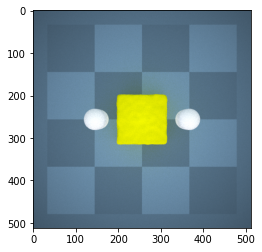

  0%|          | 0/20 [00:00<?, ?it/s]

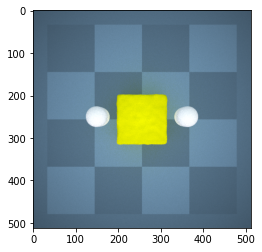

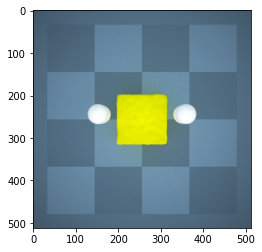

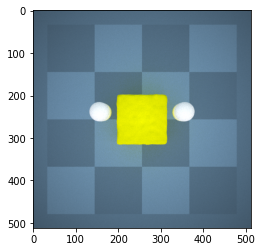

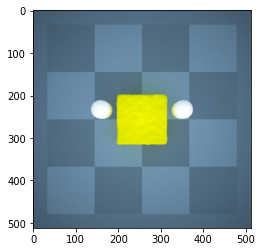

In [23]:
def set_parameters(env: TaichiEnv, yield_stress, E, nu):
    env.simulator.yield_stress.fill(yield_stress)
    _mu, _lam = E / (2 * (1 + nu)), E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame parameters
    env.simulator.mu.fill(_mu)
    env.simulator.lam.fill(_lam)
    
import glob
i = 0
task_name = 'gripper'
    
env.set_state(**state)
taichi_env = env
env.renderer.camera_pos[0] = 0.5#np.array([float(i) for i in (0.5, 2.5, 0.5)]) #(0.5, 2.5, 0.5)  #.from_numpy(np.array([[0.5, 2.5, 0.5]]))
env.renderer.camera_pos[1] = 2.5
env.renderer.camera_pos[2] = 0.5
env.renderer.camera_rot = (1.57, 0.0)

env.primitives.primitives[0].set_state(0, [0.3, 0.4, 0.5, 1, 0, 0, 0])
env.primitives.primitives[1].set_state(0, [0.7, 0.4, 0.5, 1, 0, 0, 0])
set_parameters(env, yield_stress=300, E=800, nu=0.2) # 200， 5e3, 0.2

env.render('plt')

action_dim = taichi_env.primitives.action_dim
horizon = 20
action = np.zeros([horizon, action_dim])
count = i / 50
# map count from 0...1 to -1...1
count = 2 * count - 1
updown = count * 0.12
grip_motion = np.random.uniform(0.20, 0.24)
action[:20, 2] = updown#0.1
action[:20, 1] = -0.7
action[:20, 8] = updown#0.1
action[:20, 7] = -0.7

from tqdm.notebook import tqdm
imgs = []


for idx, act in enumerate(tqdm(action, total=horizon)):

    obs = env.step(act)
    if task_name == 'gripper':
        primitive_state = [env.primitives.primitives[0].get_state(0), env.primitives.primitives[1].get_state(0)]
    else:
        primitive_state = [env.primitives.primitives[0].get_state(0)]

    if (idx+1) % 5 == 0:
        env.render(mode='plt')




model_kp #params: 443560
action_lower_lim [-0.46061096  0.          0.        ]
action_upper_lim [0.26672061 0.         0.        ]
action_lower_delta_lim [-0.66672061  0.          0.        ]
action_upper_delta_lim [0.06061096 0.         0.        ]

### Step 4/5
0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
update_iter 0/1, max: 0.0601, mean: 0.0557, std: 0.0015
(23, 3)


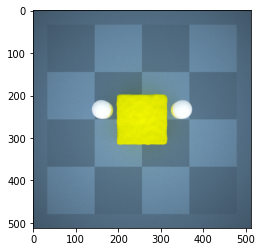

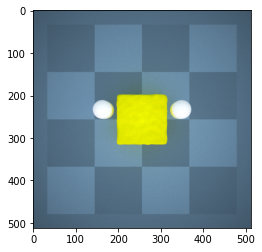

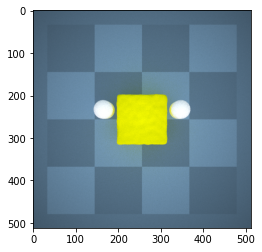

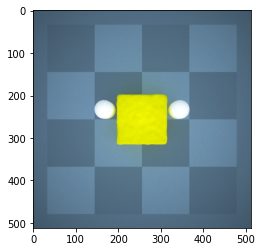

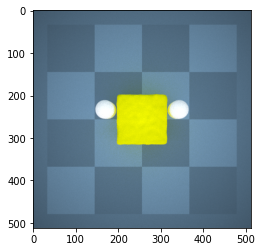

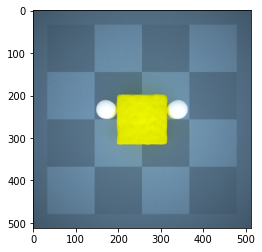

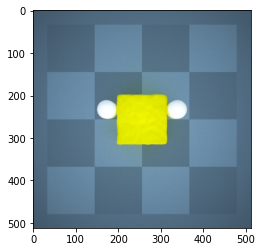

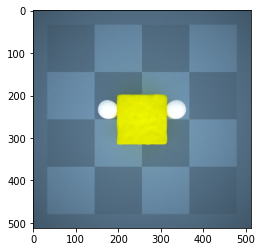

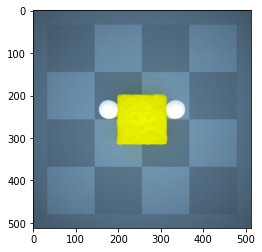

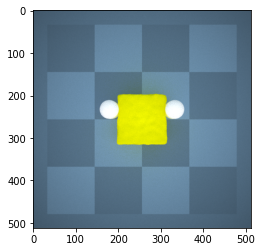

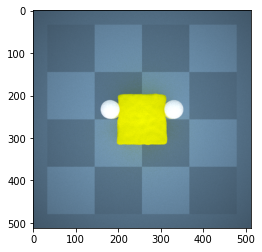

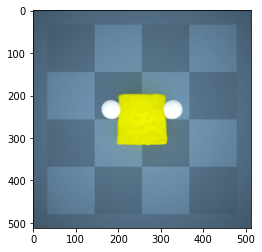

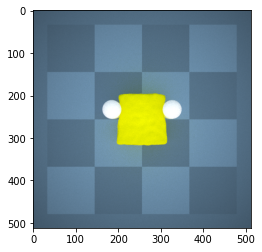

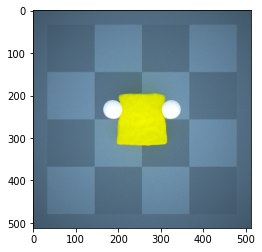

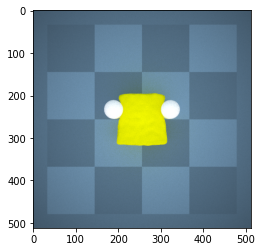

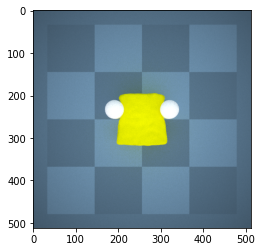

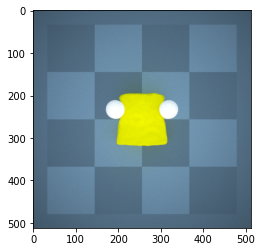

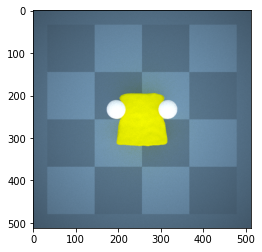

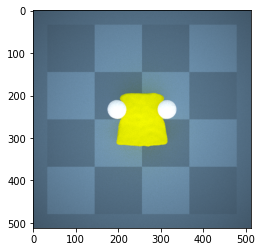

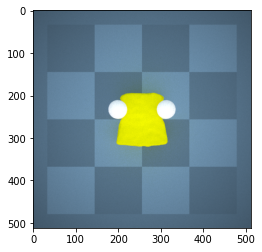

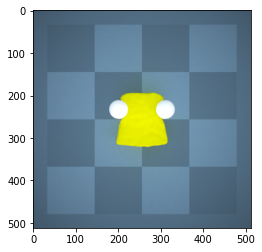

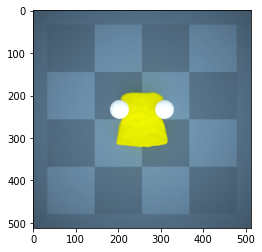

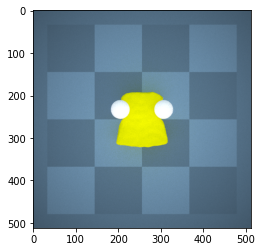

In [24]:
set_seed(args.random_seed)
use_gpu = True



# load dynamics model
model = Model(args, use_gpu)
print("model_kp #params: %d" % count_parameters(model))
model_name = 'net_epoch_%d_iter_%d.pth' % (args.eval_epoch, args.eval_iter)
model_dir = 'gripper_seqlen20'
model_path = os.path.join('dump/dump_Pinch/' + model_dir, model_name)
if use_gpu:
    pretrained_dict = torch.load(model_path)
else:
    pretrained_dict = torch.load(model_path, map_location=torch.device('cpu'))
model_dict = model.state_dict()
# only load parameters in dynamics_predictor
pretrained_dict = {
    k: v for k, v in pretrained_dict.items() \
    if 'dynamics_predictor' in k and k in model_dict}
model.load_state_dict(pretrained_dict, strict=False)
model.eval()
if use_gpu:
    model = model.cuda()

# load data (state, actions)
task_name = "gripper"
rollout_dir = f"./data/data_Gripper/train/"
n_vid = 1
n_frame = 49
data_names = ['positions', 'shape_quats', 'scene_params']

for i in range(n_vid):
    B = 1
    n_particle, n_shape = 0, 0
    all_p = []
    all_actions = []
    all_s = []
    for t in range(n_frame):
        if task_name == "gripper":
            frame_path = os.path.join(rollout_dir, str(i).zfill(3), str(t) + '.h5')
        else:
            raise NotImplementedError
        this_data = load_data(data_names, frame_path)
        if n_particle == 0 and n_shape == 0:
            n_particle, n_shape, scene_params = get_scene_info(this_data)
            scene_params = torch.FloatTensor(scene_params).unsqueeze(0)

        states = this_data[0]
        if t >= 1:
            action = (states[-2]-prev_states[-2]) / 0.02
            all_p.append(states)
            all_actions.append(action)
            all_s.append(this_data[1])
        prev_states = states


ctrl_init_idx = 4
n_look_ahead = 20
n_update_delta = 1
n_his = 4
n_sample = 100
n_update_iter_init = 1
n_update_iter = 1
emd = EarthMoverLoss()

planner = Planner(args=args, n_his=n_his, n_particle=n_particle, n_shape=n_shape, scene_params=scene_params,
                  model=model, dist_func=emd, use_gpu=use_gpu)
planner.prepare_rollout()
actions = all_actions[:n_his-1]
# import pdb; pdb.set_trace()
for i in range(n_look_ahead):
    actions.append(actions[-1])
actions = np.array(actions)
action_lower_lim, action_upper_lim, action_lower_delta_lim, action_upper_delta_lim = \
    set_action_limit(all_actions=all_actions, ctrl_init_idx=ctrl_init_idx)


st_idx = ctrl_init_idx
ed_idx = ctrl_init_idx +1#+ n_look_ahead

p_list = copy.copy(all_p[:n_his])
s_list = copy.copy(all_s[:n_his])
if use_gpu:
    state_goal = torch.cuda.FloatTensor(all_p[-1]).unsqueeze(0)[:, :300, :]
else:
    state_goal = torch.FloatTensor(all_p[-1]).unsqueeze(0)[:, :300, :]
### we note, we now have n_his states, n_his - 1 actions
for i in range(st_idx, ed_idx):
    print("\n### Step %d/%d" % (i, ed_idx))


    
    if i == st_idx or i % n_update_delta == 0:
        # update the action sequence every n_update_delta iterations
        with torch.set_grad_enabled(False):
            state_cur = torch.FloatTensor(np.stack(p_list[-n_his:]))
            # s_cur = torch.FloatTensor(np.stack(s_list[-n_his:]))


            action = planner.trajectory_optimization(
                                        state_cur=state_cur,
                                        state_goal=state_goal,
                                        act_seq=actions[i-n_his:],
                                        n_sample=n_sample,
                                        n_look_ahead=n_look_ahead - (i - ctrl_init_idx),
                                        n_update_iter=n_update_iter_init if i == st_idx else n_update_iter,
                                        action_lower_lim=action_lower_lim,
                                        action_upper_lim=action_upper_lim,
                                        action_lower_delta_lim=action_lower_delta_lim,
                                        action_upper_delta_lim=action_upper_delta_lim,
                                        use_gpu=use_gpu)
            print(action.shape)
#             obs = env.step(act)
env_act = np.zeros([action.shape[0], 12])
env_act[:, :3] = action
env_act[:, 6:9] = action * np.array([-1, 1, 1])
for i in range(action.shape[0]):
    env.step(env_act[i])
    env.render('plt')


In [14]:
action.shape

(4, 3)